# zipline(백테스팅 라이브러리)을 활용한 백테스트 예제

대상 자산의 일별 가격 데이터를 바탕으로 기초적인 몇가지 전략의 운용성과를 백테스트하는 예제입니다.

<적용 전략>
 1. Buy and Hold : 최초 거래일에 매수후 계속 보유
 2. Simple Moving Average : 현재가격이 20일 이동평균을 상향돌파하면 매수, 하향돌파하면 매도
 3. Moving Average Crossover : 단기(20일)이동평균선이 장기(100일)이동평균선을 상향돌파하면 매수, 하향돌파하면 매도
 4. MACD : MACD가 MACD signal을 상향돌파하면 매수, 하향돌파하면 매도
 5. RSI : RSI가 30% 하회시 과매도로 판단하여 매수, 70% 상회시 과매수로 판단하여 매도

---

zipline documentation : https://www.zipline.io/index.html

In [1]:
# 필요한 라이브러리 import
from zipline.api import order_percent, order, record, symbol, set_benchmark, set_slippage, order_target
from zipline.finance import commission, slippage
import zipline

import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
from collections import OrderedDict
import pytz

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 4]

In [2]:
# csv file path 설정
ktb_path = "./csv/ktb.csv"
lktb_path = "./csv/lktb.csv"
k200_path = "./csv/k200.csv"
usdkrw_path = "./csv/usdkrw.csv"

# pandas panel 생성을 위해 OrderdDict 형태로 3차원 데이터를 만들어줌
csvs = OrderedDict()

csvs['KTB'] = pd.read_csv(ktb_path, index_col=0, parse_dates=['date'])
csvs['LKTB'] = pd.read_csv(lktb_path, index_col=0, parse_dates=['date'])
csvs['K200'] = pd.read_csv(k200_path, index_col=0, parse_dates=['date'])
csvs['USD'] = pd.read_csv(usdkrw_path, index_col=0, parse_dates=['date'])

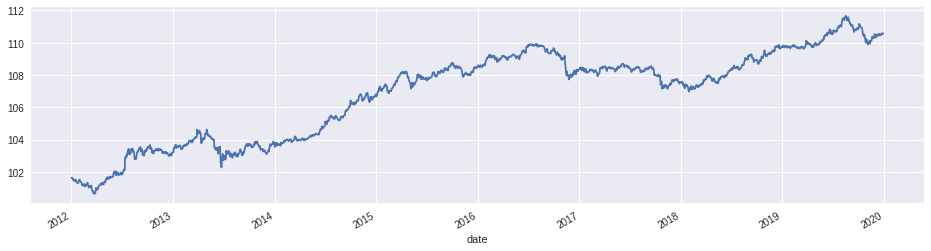

In [3]:
csvs['KTB']['close'].plot(figsize=(16,4))

In [4]:
# pandas panel 생성
data = pd.Panel(csvs)
data.minor_axis = ['open','high','low','close','volume','dividend','split']
data.major_axis = data.major_axis.tz_localize(pytz.utc) # 2018-01-02 -> 2018-01-02 00:00:00+00:00
print(data)

<class 'pandas.core.panel.Panel'>
Dimensions: 4 (items) x 1967 (major_axis) x 7 (minor_axis)
Items axis: KTB to USD
Major_axis axis: 2012-01-02 00:00:00+00:00 to 2019-12-30 00:00:00+00:00
Minor_axis axis: open to split


In [5]:
# data(한국거래소 데이터)에 맞는 calendar 설정
from trading_calendars import get_calendar
trading_calendar=get_calendar('XKRX')
# Start, End 일자 설정
start=datetime(2018,1,2,0,0,0,0,pytz.utc)
end = datetime(2019,12,30,0,0,0,0,pytz.utc)
# 초기 자본 설정
capital_base = 100000
results = []

## 1. Buy and Hold Strategies

In [6]:
# parameters 
SELECTED_STOCK = 'LKTB'

# 주요 함수 설정
def initialize(context):
    set_benchmark(symbol("KTB"))
    context.asset = symbol(SELECTED_STOCK)
    context.has_position = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):
    # trading logic
    if not context.has_position:
        # placing order, negative number for sale/short
        order_percent(context.asset, 1)
        # setting up a flag for holding a position
        context.has_position = True
        
    # record price for further inspection
    record(price=data.current(context.asset, 'price'))

In [7]:
results.append(zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,  # 기초자산 설정
    handle_data=handle_data,
    trading_calendar=trading_calendar,
    data=data
))

/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,


In [8]:
results[0].tail()

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2019-12-23 06:30:00+00:00,0.039124,0.079626,-0.003130,0.027806,0.011792,3.052504,0.0,161.38,107801.26,107801.26,...,0.0,0.0,0,1.545224,161.38,107586.50,107586.50,486,[],0.0
2019-12-24 06:30:00+00:00,0.039086,0.080370,-0.003467,0.028271,0.011783,3.051501,0.0,161.38,107875.60,107875.60,...,0.0,0.0,0,1.557247,161.38,107801.26,107801.26,487,[],0.0
2019-12-26 06:30:00+00:00,0.039048,0.079957,-0.003799,0.028364,0.011771,3.051422,0.0,161.38,107834.30,107834.30,...,0.0,0.0,0,1.548017,161.38,107875.60,107875.60,488,[],0.0
2019-12-27 06:30:00+00:00,0.039076,0.076653,-0.004842,0.027992,0.011763,3.054452,0.0,161.38,107503.90,107503.90,...,0.0,0.0,0,1.480864,161.38,107834.30,107834.30,489,[],0.0
2019-12-30 06:30:00+00:00,0.039041,0.077727,-0.004887,0.028364,0.011753,3.054352,0.0,161.38,107611.28,107611.28,...,0.0,0.0,0,1.498936,161.38,107503.90,107503.90,490,[],0.0


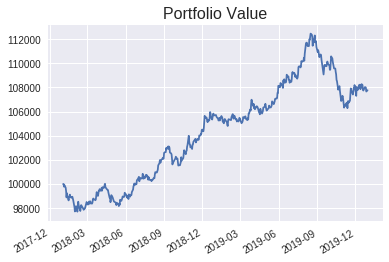

Final portfolio value (including cash): 107772.66￦


In [9]:
# Portfolio Value Plotting
plt.title("Portfolio Value", fontsize=16)
results[0].portfolio_value.plot()
plt.show()

# print Final Portfolio Value
print('Final portfolio value (including cash): {amount}{currency}'.format(
    amount = np.round(results[0].portfolio_value[-1], 2), currency = "￦"))

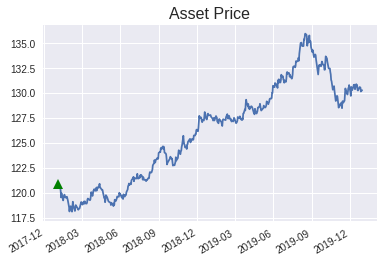

In [10]:
# Asset Price Plotting
plt.title("Asset Price", fontsize=16)
results[0].price.plot()

# mark transactions
perf_trans = results[0].loc[[t != [] for t in results[0].transactions]]
buys = perf_trans.loc[[t[0]['amount'] >
                       0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] <
                        0 for t in perf_trans.transactions]]
plt.plot(buys.index, results[0].price.loc[buys.index], '^',
           markersize=10, color='g', label='buy')
plt.plot(sells.index, results[0].price.loc[sells.index],
           'v', markersize=10, color='r', label='sell')
plt.show()

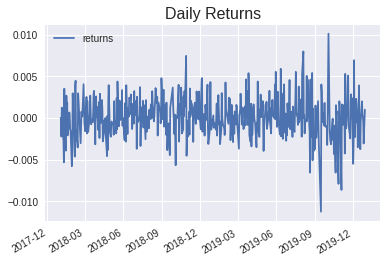

In [11]:
# daily returns
results[0].returns.plot()
plt.title("Daily Returns", fontsize=16)
plt.legend()
plt.show()


## 2. Simple Moving Average

In [12]:
# parameters 
MA_PERIODS = 20
SELECTED_STOCK = 'LKTB'

# 주요 함수 설정
def initialize(context):
    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_position = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):
    price_history = data.history(context.asset, fields="price", bar_count=MA_PERIODS, frequency="1d")
    ma = price_history.mean()
    
    # cross up
    if (price_history[-2] < ma) & (price_history[-1] > ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    # cross down
    elif (price_history[-2] > ma) & (price_history[-1] < ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           moving_average=ma)
    
results.append(zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,  # 기초자산 설정
    handle_data=handle_data,
    trading_calendar=trading_calendar,
    data=data
))

/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


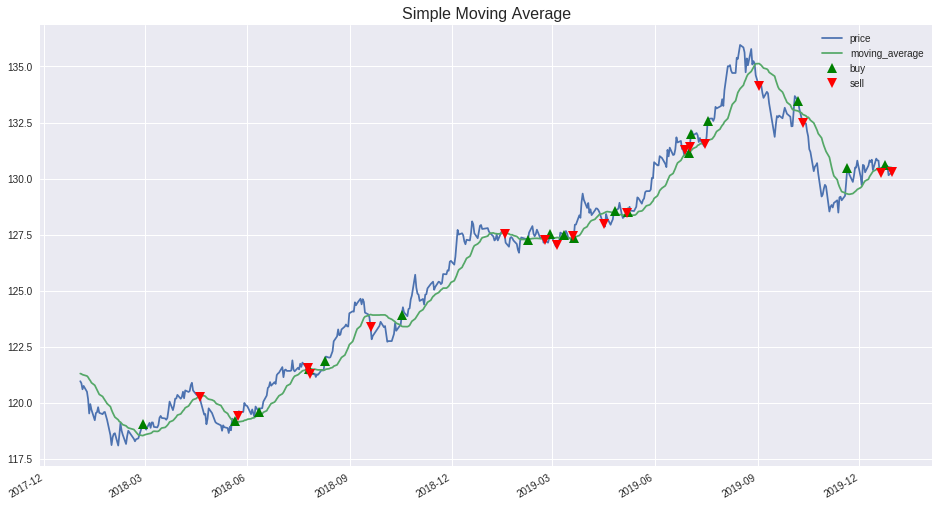

In [13]:
results[1][['price','moving_average']].plot(figsize=(16,9))
plt.title("Simple Moving Average", fontsize=16)

# mark transactions
perf_trans = results[1].loc[[t != [] for t in results[1].transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
plt.plot(buys.index, results[1].price.loc[buys.index], '^', markersize=10, color='g', label='buy')
plt.plot(sells.index, results[1].price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
plt.legend()

plt.show()

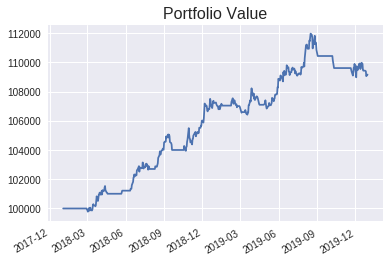

Final portfolio value (including cash): 109172.46￦


In [14]:
# Portfolio Value Plotting
plt.title("Portfolio Value", fontsize=16)
results[1].portfolio_value.plot()
plt.show()

# print Final Portfolio Value
print('Final portfolio value (including cash): {amount}{currency}'.format(
    amount = np.round(results[1].portfolio_value[-1], 2), currency = "￦"))

## 3. Moving Average Crossover

In [15]:
# parameters 
SELECTED_STOCK = 'LKTB'
SLOW_MA_PERIODS = 100
FAST_MA_PERIODS = 20

def initialize(context):
    
    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_position = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):

    fast_ma = data.history(context.asset, 'price', bar_count=FAST_MA_PERIODS, frequency="1d").mean()
    slow_ma = data.history(context.asset, 'price', bar_count=SLOW_MA_PERIODS, frequency="1d").mean()

    # Trading logic
    if (fast_ma > slow_ma) & (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
    elif (fast_ma < slow_ma) & (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False

    record(price=data.current(context.asset, 'price'),
           fast_ma=fast_ma,
           slow_ma=slow_ma)
    
results.append(zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,  # 기초자산 설정
    handle_data=handle_data,
    trading_calendar=trading_calendar,
    data=data
))

/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:704: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/opt/conda/envs/backtest/lib/python3.5/site-packages/empyrical/stats.py:790: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


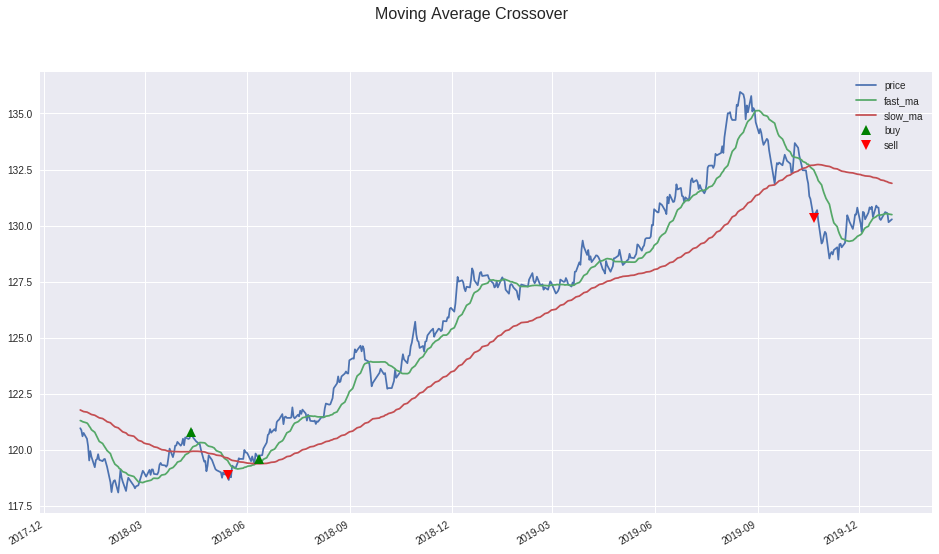

In [16]:
results[2][['price','fast_ma', 'slow_ma']].plot(figsize=(16,9))
plt.suptitle("Moving Average Crossover", fontsize=16)

# mark transactions
perf_trans = results[2].loc[[t != [] for t in results[2].transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
plt.plot(buys.index, results[2].price.loc[buys.index], '^', markersize=10, color='g', label='buy')
plt.plot(sells.index, results[2].price.loc[sells.index], 'v', markersize=10, color='r', label='sell')
plt.legend()

plt.show()

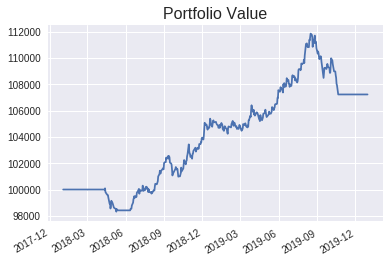

Final portfolio value (including cash): 107225.94￦


In [17]:
# Portfolio Value Plotting
plt.title("Portfolio Value", fontsize=16)
results[2].portfolio_value.plot()
plt.show()

# print Final Portfolio Value
print('Final portfolio value (including cash): {amount}{currency}'.format(
    amount = np.round(results[2].portfolio_value[-1], 2), currency = "￦"))

## 4. MACD

In [ ]:
import talib as ta

# parameters ----
SELECTED_STOCK = 'LKTB'

 #initialize the strategy 
def initialize(context):

    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_position = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=34, frequency="1d")
    macd, macdsignal, macdhist = ta.MACD(price_history, 12, 26, 9) 
    
    if (macdsignal[-1] < macd[-1]) and (not context.has_position):
        order_percent(context.asset, 1.0)
        context.has_position = True
        
    if (macdsignal[-1] > macd[-1]) and (context.has_position):
        order_target(context.asset, 0)
        context.has_position = False
        
    record(macd =  macd[-1], macdsignal = macdsignal[-1], macdhist = macdhist[-1], price=price_history[-1]) 
    
results.append(zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,  # 기초자산 설정
    handle_data=handle_data,
    trading_calendar=trading_calendar,
    data=data
))

In [ ]:
results[3][['macd', 'macdsignal']].plot(figsize=(16,9))
plt.suptitle("MACD", fontsize=16)

# mark transactions
perf_trans = results[3].loc[[t != [] for t in results[3].transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
plt.plot(buys.index, results[3].macd.loc[buys.index], '^', markersize=10, color='g', label='buy')
plt.plot(sells.index, results[3].macd.loc[sells.index], 'v', markersize=10, color='r', label='sell')
plt.legend()

plt.show()

In [ ]:
# Portfolio Value Plotting
plt.title("Portfolio Value", fontsize=16)
results[3].portfolio_value.plot()
plt.show()

# print Final Portfolio Value
print('Final portfolio value (including cash): {amount}{currency}'.format(
    amount = np.round(results[3].portfolio_value[-1], 2), currency = "￦"))

## 5. RSI

In [ ]:
import talib as ta

# parameters ----
SELECTED_STOCK = 'LKTB'
UPPER = 70
LOWER = 30
RSI_PERIOD = 14

#initialize the strategy 
def initialize(context):

    set_benchmark(symbol('LKTB'))
    context.asset = symbol(SELECTED_STOCK)
    context.has_position = False
    context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
    context.set_slippage(slippage.FixedSlippage(spread=0))
    
def handle_data(context, data):
    
    price_history = data.history(context.asset, fields="price", bar_count=RSI_PERIOD+1, frequency="1d")
    rsi = ta.RSI(price_history, timeperiod=RSI_PERIOD)
    
    if rsi[-1] < LOWER and not context.has_position:
        order_percent(context.asset, 1.0)
        context.has_position = True
      
    if rsi[-1] > UPPER and context.has_position:
        order_target(context.asset, 0)
        context.has_position = False
     
    record(rsi=rsi[-1], price=price_history[-1]) 
    
results.append(zipline.run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100000,  # 기초자산 설정
    handle_data=handle_data,
    trading_calendar=trading_calendar,
    data=data
))

In [ ]:
results[4][['rsi']].plot(figsize=(16,9))
plt.axhline(y=70, color='r')
plt.axhline(y=30, color='g')

plt.suptitle("RSI", fontsize=16)

# mark transactions
perf_trans = results[4].loc[[t != [] for t in results[4].transactions]]
buys = perf_trans.loc[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
sells = perf_trans.loc[[t[0]['amount'] < 0 for t in perf_trans.transactions]]
plt.plot(buys.index, results[4].rsi.loc[buys.index], '^', markersize=10, color='g', label='buy')
plt.plot(sells.index, results[4].rsi.loc[sells.index], 'v', markersize=10, color='r', label='sell')
plt.legend()

plt.show()

In [ ]:
# Portfolio Value Plotting
plt.title("Portfolio Value", fontsize=16)
results[4].portfolio_value.plot()
plt.show()

# print Final Portfolio Value
print('Final portfolio value (including cash): {amount}{currency}'.format(
    amount = np.round(results[4].portfolio_value[-1], 2), currency = "￦"))

In [ ]:
#pyfolio report 생성
import pyfolio as pf
import numpy as np
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results[4])
benchmark_period_return = results1['benchmark_period_return']
# Convert benchmark returns to daily returns
#daily_returns = (1 + benchmark_period_return) / (1 + benchmark_period_return.shift()) - 1
daily_benchmark_returns = np.exp(np.log(benchmark_period_return + 1.0).diff()) - 1
sheets = pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=daily_benchmark_returns)

---

In [ ]:
import empyrical as ep

def get_performance_summary(returns):
    '''
    Calculate selected performance evaluation metrics using provided returns.
    
    Parameters
    ------------
    returns : pd.Series
        Series of returns we want to evaluate

    Returns
    -----------
    stats : pd.Series
        The calculated performance metrics
        
    '''
    stats = {'annualized_returns': ep.annual_return(returns),
             'cumulative_returns': ep.cum_returns_final(returns),
             'annual_volatility': ep.annual_volatility(returns),
             'sharpe_ratio': ep.sharpe_ratio(returns),
             'sortino_ratio': ep.sortino_ratio(returns),
             'max_drawdown': ep.max_drawdown(returns)}
    return pd.Series(stats)

In [ ]:
perf = []
for r in results:
    perf.append(get_performance_summary(r.returns))

perf_df = pd.DataFrame({'1.Buy and Hold': perf[0],
                        '2.Simple Moving Average': perf[1],
                        '3.Moving Average Crossover': perf[2],
                        '4.MACD': perf[3],
                        '5.RSI': perf[4]})
perf_df.transpose()